In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from sklearn import svm
from sklearn.model_selection import GridSearchCV, learning_curve, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report

In [2]:
def preprocess_mfccs(arr):
    '''
    Simple method to handle the complex MFCC coefs that are produced during preprocessing. This means:
    1. (For now), discarding one of the channels of the MFCC coefs
    2. Collapsing any empty dimensions
    Also transposes the vector so we can easily iterate through each coefficient
    '''
    return np.transpose(arr.squeeze()[0])

# Load the CSV file with URLs and Gender information
with open('./.cache/local.csv', 'rb') as tarteel_csv:
    tarteel_df = pd.read_csv(tarteel_csv)
    tarteel_df = tarteel_df[['URL to Recording', 'Gender']]
    recording_urls = tarteel_df['URL to Recording']
    recording_filenames_from_csv = recording_urls.str.extract('https://tarteel-data.s3.amazonaws.com/media/([_\d]+)\.wav.+')
    
def get_gender_of_recitation(recording_filename):
    recording_filename = recording_filename[:-10]
    matching_audio_file = recording_filenames_from_csv[0].str.startswith(recording_filename).fillna(False)
    tarteel_df_out = tarteel_df[matching_audio_file]
    if tarteel_df_out.empty:
        return None
    if tarteel_df_out['Gender'].iloc[0] == 'male':
        return 1
    if tarteel_df_out['Gender'].iloc[0] == 'female':
        return 0 
    return None

def build_dataset(local_coefs_dir, surahs, n=100):
    '''
    Builds a dataset to be used with the gender classification model.
    
    :param local_coefs_dir: a string with the path of the mfcc coefficients 
    '''
    
    def get_classifier_data(n):
        count = 0
        classifier_input_data = []
        gender_data = []
        for surah_num in surahs:
            local_surah_dir = os.path.join(local_coefs_dir, "s" + str(surah_num))
            for _, ayah_directories, _ in os.walk(local_surah_dir):
                for ayah_directory in ayah_directories:
                    ayah_num = ayah_directory[1:]
                    local_ayah_dir = os.path.join(local_surah_dir, ayah_directory)
                    for _, _, recording_filenames in os.walk(local_ayah_dir):
                        for recording_filename in recording_filenames:
                            local_coefs_path = os.path.join(local_ayah_dir, recording_filename)
                            mfccs = np.load(local_coefs_path)
                            mfccs = preprocess_mfccs(mfccs)
                            
                            # Classifier input features are the means of each of the coeffs
                            classifier_input = []
                            for mfcc in mfccs:
                                classifier_input.append(np.mean(mfcc))

                            gender = get_gender_of_recitation(recording_filename)
                            if gender is not None:  # Only if gender is known, add the recording to the list
                                classifier_input_data.append(classifier_input)
                                gender_data.append(gender)
                                count += 1
                                if count == n:
                                    return classifier_input_data, gender_data

        return classifier_input_data, gender_data
    
    
    classifier_input_data, gender_data = get_classifier_data(n=n)
    return np.array(classifier_input_data), np.array(gender_data)

In [3]:
xtrain, ytrain = build_dataset("../.outputs40/mfcc", surahs=[2,3,4,26], n=600)

print("Dataset info ({} recordings): ".format(ytrain.size))
unique, counts = np.unique(ytrain, return_counts=True)
gender_counts = dict(zip(unique, counts))
print("Number of recordings   (male):", gender_counts[1])
print("Number of recordings (female):", gender_counts[0])

Dataset info (571 recordings): 
Number of recordings   (male): 485
Number of recordings (female): 86


### SVM parameter tuning

In [4]:
Cs = [50,60,70,80,90,100,150,200,250]

param_grid = [
    {'kernel': ['linear'], 'C': Cs},
    {'kernel': ['rbf'], 'C': Cs},
    {'kernel': ['poly'], 'C': Cs,
                 'degree': [1,2,3,4,5]}
]
cv = StratifiedKFold(5).split(xtrain, ytrain)
grid_search = GridSearchCV(svm.SVC(gamma='scale'), param_grid=param_grid,
                           scoring='f1_macro', iid=False, cv=cv)
grid_search.fit(xtrain, ytrain)
print("Best options:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best options: {'C': 200, 'degree': 3, 'kernel': 'poly'}
Best score: 0.9570681592998396


### Model Evaluation

In [5]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(xtrain, ytrain, test_size=0.2, random_state=1807)
model = svm.SVC(kernel='poly', gamma='scale', C=200, degree=3)
model.fit(Xtrain, Ytrain)
Ypred = model.predict(Xtest)

print(classification_report(Ytest, Ypred, target_names=['female', 'male']))

              precision    recall  f1-score   support

      female       0.96      0.92      0.94        24
        male       0.98      0.99      0.98        91

   micro avg       0.97      0.97      0.97       115
   macro avg       0.97      0.95      0.96       115
weighted avg       0.97      0.97      0.97       115



### Learning curve

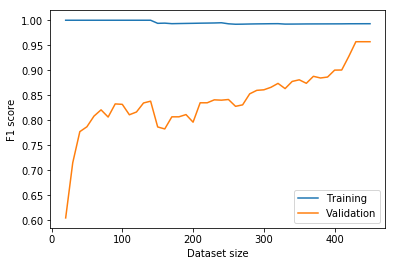

In [8]:
model = svm.SVC(kernel='poly', gamma='scale', C=200, degree=3)
cv = StratifiedKFold(5).split(xtrain, ytrain)

train_sizes = range(20, 456, 10)
train_sizes, train_scores, valid_scores \
            = learning_curve(model, xtrain, ytrain,
                     train_sizes=train_sizes, cv=cv,
                     scoring='f1_macro')

plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Training")
plt.plot(train_sizes, np.mean(valid_scores, axis=1), label="Validation")
plt.xlabel("Dataset size")
plt.ylabel("F1 score")
plt.legend()